<a href="https://colab.research.google.com/github/EmaSuriano/deep-learning-group-7/blob/main/ema/from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kaggle opencv-python seaborn tensorflow numpy

In [19]:
# Imports
import numpy as np
import pandas as pd

import json
import random

import os
from PIL import Image

import matplotlib.pyplot as plt

from tensorflow import keras as K

# Enable mixed precision
K.mixed_precision.set_global_policy('mixed_float16')

## Carga del Dataset


In [3]:
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [4]:
def resize_and_pad_image(image, img_size):
    if image.mode in ("RGBA", "LA"):
        # Create a white background image (255, 255, 255 = white)
        white_background = Image.new("RGB", image.size, (255, 255, 255))
        # Paste the image onto the white background, using the alpha channel as a mask
        white_background.paste(image.convert("RGB"), mask=image.split()[-1])
        image = white_background  # Update image to have white background

    original_width, original_height = image.size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions based on aspect ratio
    if original_width > original_height:
        new_width = img_size[0]
        new_height = int(img_size[0] / aspect_ratio)
    else:
        new_height = img_size[1]
        new_width = int(img_size[1] * aspect_ratio)

    # Resize the image with high-quality downsampling
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank image with the target size (white padding)
    padded_image = Image.new("RGB", img_size, (255, 255, 255))

    # Calculate position to paste the resized image onto the padded image
    x_offset = (img_size[0] - resized_image.size[0]) // 2
    y_offset = (img_size[1] - resized_image.size[1]) // 2

    # Paste the resized image onto the padded image
    padded_image.paste(resized_image, (x_offset, y_offset))

    return padded_image

In [5]:
# import cv2
from pathlib import Path

valid_img_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

# Resolucion de imagenes de 128 x 128
img_res = 128

X = []
y = []
labelNames = {}

print("[INFO]: Leyendo imagenes de poses")
for id, pose in enumerate(df.itertuples()):
    print(f"[INFO]: Procesando pose: {pose.sanskrit_name} / {pose.english_name}")
    labelNames[id] = pose.english_name

    # Obtengo la carpeta de imagenes de la pose
    folder = f"{DS_PATH}/{pose.sanskrit_name}"

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        if Path(img_path).suffix.lower() not in valid_img_extensions:
            print(f"[WARN]: Formato {img_path} no valido")
            continue

        img = K.utils.load_img(img_path)

        img = resize_and_pad_image(img, (img_res, img_res))

        X.append(img)
        y.append(id)


# Convertir a numpy array
X = np.array(X)
y = np.array(y)

[INFO]: Leyendo imagenes de poses
[INFO]: Procesando pose: Navasana / Boat
[INFO]: Procesando pose: Ardha Navasana / Half-Boat
[INFO]: Procesando pose: Dhanurasana / Bow
[INFO]: Procesando pose: Setu Bandha Sarvangasana / Bridge
[INFO]: Procesando pose: Baddha Konasana / Butterfly
[INFO]: Procesando pose: Ustrasana / Camel
[INFO]: Procesando pose: Marjaryasana / Cat
[INFO]: Procesando pose: Bitilasana / Cow
[INFO]: Procesando pose: Utkatasana / Chair
[INFO]: Procesando pose: Balasana / Child's Pose


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO]: Procesando pose: Sivasana / Corpse
[INFO]: Procesando pose: Alanasana / Crescent Lunge
[INFO]: Procesando pose: Bakasana / Crow
[INFO]: Procesando pose: Ardha Pincha Mayurasana / Dolphin
[INFO]: Procesando pose: Adho Mukha Svanasana / Downward-Facing Dog
[INFO]: Procesando pose: Garudasana / Eagle
[INFO]: Procesando pose: Utthita Hasta Padangusthasana / Extended Hand to Toe
[INFO]: Procesando pose: Utthita Parsvakonasana / Extended Side Angle
[INFO]: Procesando pose: Pincha Mayurasana / Forearm Stand
[INFO]: Procesando pose: Uttanasana / Forward Bend with Shoulder Opener
[INFO]: Procesando pose: Ardha Chandrasana / Half-Moon
[INFO]: Procesando pose: Adho Mukha Vrksasana / Handstand
[INFO]: Procesando pose: Anjaneyasana / Low Lunge
[INFO]: Procesando pose: Supta Kapotasana / Pigeon
[INFO]: Procesando pose: Eka Pada Rajakapotasana / King Pigeon
[INFO]: Procesando pose: Phalakasana / Plank
[INFO]: Procesando pose: Halasana / Plow
[INFO]: Procesando pose: Parsvottanasana / Pyramid


## Sample Preview

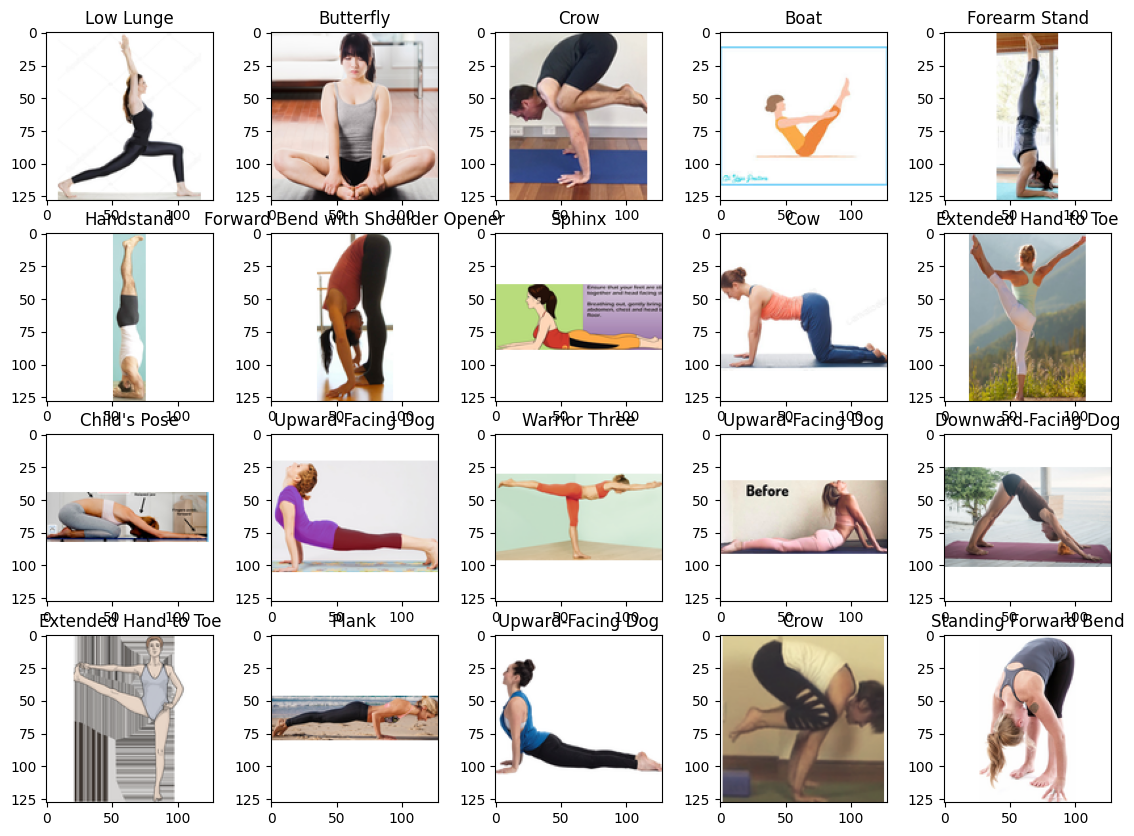

In [6]:
fig = plt.figure(figsize=(14, 10))

samples = np.random.randint(0, len(X), 20)

for i, img_idx in enumerate(samples):
    fig.add_subplot(4, 5, i + 1)

    plt.imshow(X[img_idx])
    plt.title(labelNames[y[img_idx]])

plt.show()

## Analisis de la distribucion

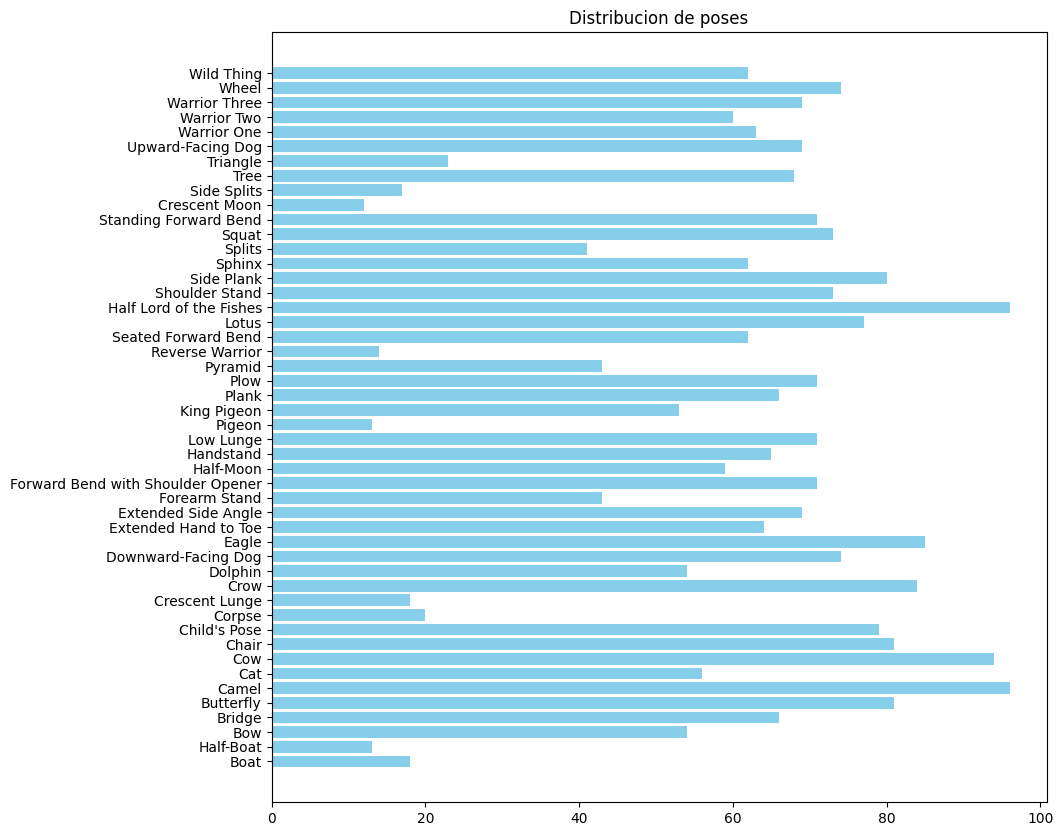

In [7]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(list(labelNames.values()), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

## Balanceo de clases - Oversampling

In [8]:
# ImageDataGenerator for oversampling
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


def oversample_imgs(imgs, amount):
    oversamples = []

    for _ in range(amount):
        image = imgs[np.random.randint(len(imgs))]
        new_img = datagen.random_transform(image)
        oversamples.append(new_img)

    return oversamples


target_count = np.max(y_counts)

for label in np.unique(y):
    X_filtered = X[y == label]
    num_augmentations = target_count - len(X_filtered)

    if num_augmentations > 0:
        print(f"[INFO]: Nuevas {num_augmentations} poses de {labelNames[label]}")
        img_random_order = np.random.permutation(X_filtered)

        X_aug = np.array(
            [
                datagen.random_transform(img_random_order[i % len(X_filtered)])
                for i in range(num_augmentations)
            ]
        )
        y_aug = np.array([label] * num_augmentations)

        X = np.append(X, X_aug, axis=0)
        y = np.append(y, y_aug, axis=0)

[INFO]: Nuevas 78 poses de Boat
[INFO]: Nuevas 83 poses de Half-Boat
[INFO]: Nuevas 42 poses de Bow
[INFO]: Nuevas 30 poses de Bridge
[INFO]: Nuevas 15 poses de Butterfly
[INFO]: Nuevas 40 poses de Cat
[INFO]: Nuevas 2 poses de Cow
[INFO]: Nuevas 15 poses de Chair
[INFO]: Nuevas 17 poses de Child's Pose
[INFO]: Nuevas 76 poses de Corpse
[INFO]: Nuevas 78 poses de Crescent Lunge
[INFO]: Nuevas 12 poses de Crow
[INFO]: Nuevas 42 poses de Dolphin
[INFO]: Nuevas 22 poses de Downward-Facing Dog
[INFO]: Nuevas 11 poses de Eagle
[INFO]: Nuevas 32 poses de Extended Hand to Toe
[INFO]: Nuevas 27 poses de Extended Side Angle
[INFO]: Nuevas 53 poses de Forearm Stand
[INFO]: Nuevas 25 poses de Forward Bend with Shoulder Opener
[INFO]: Nuevas 37 poses de Half-Moon
[INFO]: Nuevas 31 poses de Handstand
[INFO]: Nuevas 25 poses de Low Lunge
[INFO]: Nuevas 83 poses de Pigeon
[INFO]: Nuevas 43 poses de King Pigeon
[INFO]: Nuevas 30 poses de Plank
[INFO]: Nuevas 25 poses de Plow
[INFO]: Nuevas 53 poses de

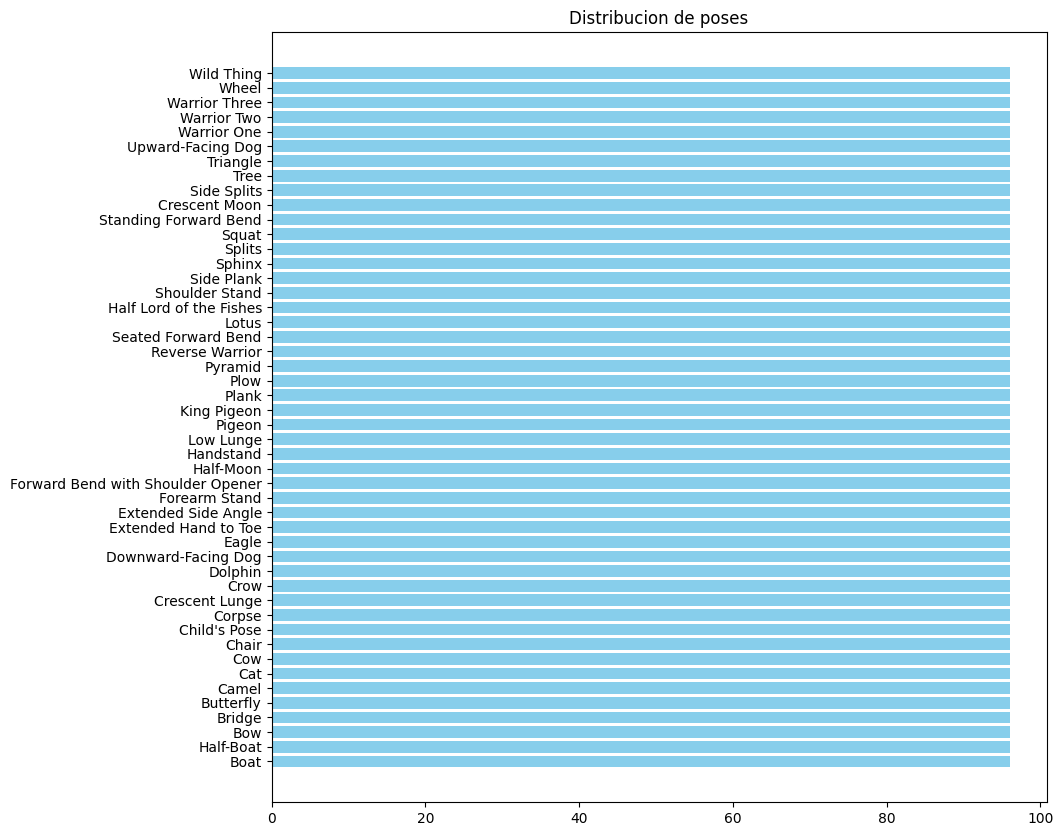

In [9]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(list(labelNames.values()), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output the results
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Check the class distribution
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

X_train: (3225, 128, 128, 3)
y_train: (3225,)
X_test: (1383, 128, 128, 3)
y_test: (1383,)
Class distribution in y_train: [67 67 67 67 68 67 67 67 67 67 67 67 68 67 67 67 67 67 67 68 67 67 67 67
 68 67 68 68 67 67 67 67 67 67 67 67 67 68 67 67 68 67 67 68 67 67 67 67]
Class distribution in y_test: [29 29 29 29 28 29 29 29 29 29 29 29 28 29 29 29 29 29 29 28 29 29 29 29
 28 29 28 28 29 29 29 29 29 29 29 29 29 28 29 29 28 29 29 28 29 29 29 29]


## Normalization

In [11]:
from sklearn.preprocessing import LabelBinarizer

# Img normalization
X_train_n = X_train / 255
X_test_n = X_test / 255

# One hot encoding for labels
lb = LabelBinarizer()
y_train_n = lb.fit_transform(y_train)
y_test_n = lb.transform(y_test)

## Data Augmentation

In [12]:
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest",  # Fill mode to avoid clipping of images (reflect, wrap, constant)
    validation_split=0.3,
)

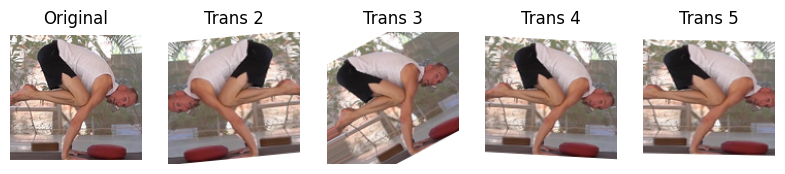

In [13]:
sample = random.randint(0, len(X_train_n))

img_orig = X_train_n[sample]

fig = plt.figure(figsize=(16, 10))

fig.add_subplot(4, 8, 1)
plt.imshow(img_orig)
plt.title("Original")
plt.axis("off")

# # Show transformations
# fig = plt.figure(figsize=(8, 8))
for n in range(2, 6):
    fig.add_subplot(4, 8, n)
    img = datagen.random_transform(img_orig)

    plt.imshow(img)
    plt.title(f"Trans {n}")
    plt.axis("off")

plt.show()

## Model definition

> Reemplazar esto por el modelo que quieran entrenar! ⚠️

Este es un ejemplo de un modelo pre-entrenado en modo forward (no hay capas adicionales).

In [24]:
# SMALLER MODEL

input_shape = (img_res, img_res, 3)
inputs = K.layers.Input(shape=input_shape)

# First block - Regular Conv2D for initial feature extraction
x = K.layers.Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
x = K.layers.BatchNormalization()(x)
x = K.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Second block - SeparableConv2D to reduce parameters
x = K.layers.SeparableConv2D(32, (3, 3), padding="same", activation="relu")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = K.layers.Dropout(0.3)(x)

# Third block - SeparableConv2D
x = K.layers.SeparableConv2D(64, (3, 3), padding="same", activation="relu")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = K.layers.Dropout(0.4)(x)

# Global Average Pooling instead of Flatten
x = K.layers.GlobalAveragePooling2D()(x)

# Final classification layer
predictions = K.layers.Dense(len(labelNames), activation="softmax")(x)

model = K.models.Model(inputs=inputs, outputs=predictions)

# Compile model
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 64, 64, 32)          │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 32, 32, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 48)                  │           3,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,104 (27.75 KB)

 Trainable params: 6,880 (26.88 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
labelNames

In [27]:
input_shape = (img_res, img_res, 3)



# Define the list of layers for the CNN
layers = [
    # First Block
    K.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    K.layers.BatchNormalization(),
    K.layers.MaxPooling2D(pool_size=(2, 2)),
    K.layers.Dropout(0.2),

    # Second Block
    K.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    K.layers.BatchNormalization(),
    K.layers.MaxPooling2D(pool_size=(2, 2)),
    K.layers.Dropout(0.3),

    # Third Block
    K.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    K.layers.BatchNormalization(),
    K.layers.MaxPooling2D(pool_size=(2, 2)),
    K.layers.Dropout(0.4),

    # Global Average Pooling
    K.layers.GlobalAveragePooling2D(),

    # Softmax classifier
    K.layers.Dense(len(labelNames), activation="softmax")
]

# Input Layer
inputs = K.layers.Input(shape=input_shape)

# Build the model using the list of layers
x = inputs
for layer in layers:
    x = layer(x)

# Create the model
model = K.models.Model(inputs=inputs, outputs=x)


# Compilar el modelo
print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.Adam(
        learning_rate=0.001,
        # beta_1=0.9,
        # beta_2=0.999,
        # epsilon=1e-08,
    ),
    metrics=["accuracy"],
)

model.summary()

[INFO]: Compilando el modelo...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 295,504 (1.13 MB)

 Trainable params: 294,352 (1.12 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Early stopping in case it stops converging
early_stopping = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=40,
    restore_best_weights=True,
)

# Use datageneration for training and validation data
train_data = datagen.flow(X_train_n, y_train_n, batch_size=64, subset="training")
validation_data = datagen.flow(X_train_n, y_train_n, batch_size=64, subset="validation")


# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    # callbacks=[early_stopping],
)

[INFO]: Entrenando la red...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 77s 915ms/step - accuracy: 0.0218 - loss: 4.3874 - val_accuracy: 0.0248 - val_loss: 4.0298
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 324ms/step - accuracy: 0.0880 - loss: 3.6229 - val_accuracy: 0.0217 - val_loss: 4.3822
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.1171 - loss: 3.4195 - val_accuracy: 0.0196 - val_loss: 4.8228
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.1379 - loss: 3.2559 - val_accuracy: 0.0238 - val_loss: 4.9778
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.1568 - loss: 3.1779 - val_accuracy: 0.0238 - val_loss: 5.8993
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.1602 - loss: 3.0604 - val_accuracy: 0.0196 - val_loss: 8.3067
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.1763 - loss: 2.9748 - val_accuracy: 0.0465 - val_loss: 6.3964
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accur

In [ ]:
from sklearn.metrics import classification_report

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=64)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()